In [ ]:
# '=== Header Start ==='
# Title:       Section6_Read_Stemcell-derived_Peri-gastruloids
# Author:      Wanqi Li
# Date:        20240513
# Purpose:     Read data of Stemcell-derived Peri-gastruloids mentioned in Section 6
# Source Data: Liu, L. et al. Modeling post-implantation stages of human development 
#              into early organogenesis with stem-cell-derived peri-gastruloids. 
#              Cell 186, 3776-3792.e16 (2023).
# '=== Header End ==='

In [13]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import random
import pickle
import igraph

In [2]:
data_path = "../data/Dataset_Stemcell-derived Peri-gastruloids/"

In [7]:
Data_Raw = sc.read_10x_h5(data_path + "GSE232861_RAW/GSM7384960_filtered_feature_bc_matrix.h5")
Data_Raw

/home/zhiyuanlab/miniconda3/envs/test_wq/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 12181 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

In [71]:
Data_obs = pd.read_csv(data_path + "Barcodes_to_Celltypes.txt",
                       sep="\t", index_col=0)
Data_obs

,cluster,celltype
cellname,,
AAACCCAAGATAACAC-1,3,PS
AAACCCAAGCGATGAC-1,4,Ect
AAACCCAAGTCGCGAA-1,7,Intermediate
AAACCCAGTCAAGGCA-1,0,Adv.meso
AAACCCATCACCTCAC-1,4,Ect
...,...,...
TTTGTTGCAGGATGAC-1,0,Adv.meso
TTTGTTGGTGGACCTC-1,1,Epi
TTTGTTGGTTCTATCT-1,2,Nas.meso


In [173]:
# downsample 20% cells by cell type
# celltype_list = np.unique(Data_obs["celltype"])
celltype_list = ["Epi", "Ect", "PS", "Nas.meso", "Adv.meso", "DE", "Extra.endo", "ExE.meso"]
cell_downsample_list = []
for celltype in celltype_list:
    cell_list_tmp = Data_obs.loc[Data_obs["celltype"] == celltype,].index
    cell_list_tmp = cell_list_tmp.tolist()
    sample_size = int(len(cell_list_tmp) * 0.2)
    random.seed(5)
    cell_list = random.sample(cell_list_tmp, sample_size)
    cell_downsample_list = cell_downsample_list + cell_list

In [141]:
celltype_list

array(['Adv.meso', 'Allantois', 'Blood/endothelial', 'DE', 'Dividing ect',
       'Ect', 'Epi', 'ExE.meso', 'Extra.endo', 'Intermediate', 'Nas.meso',
       'PS', 'SE'], dtype=object)

In [189]:
# with open(data_path + "cell_downsample_list.pkl", 'wb') as f:
#     pickle.dump(cell_downsample_list, f)
with open(data_path + "cell_downsample_list.pkl", 'rb') as f:
    cell_downsample_list = pickle.load(f)

In [198]:
Data_downsample = Data_Raw[cell_downsample_list,]
Data_downsample.obs = Data_obs.loc[cell_downsample_list,]
Data_downsample.var_names_make_unique
# basic filtering
# sc.pp.filter_cells(Data_downsample, min_genes=500) #remove cells expressing less than 200 genes
# sc.pp.filter_genes(Data_downsample, min_cells=10) # remove genes that express in less than 3 cells
Data_downsample

/home/zhiyuanlab/miniconda3/envs/test_wq/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1930 × 33538
    obs: 'cluster', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome'

In [200]:
## Normalization
sc.pp.normalize_total(Data_downsample, target_sum=1e6) # normalize to 10,000 reads per cell, correcting for differences in sequencing depth (capture rates)
sc.pp.log1p(Data_downsample) # log transform the data, why? to make the data more normally distributed

In [201]:
# select top 2000 or 3000 genes
sc.pp.highly_variable_genes(Data_downsample, n_top_genes=2000) # select the top 2000 highly variable genes

In [202]:
# sc.pp.scale(Data_downsample) #
sc.tl.pca(Data_downsample, use_highly_variable=True) # perform PCA on the highly variable genes
# sc.pl.pca_loadings(Data_downsample)

/home/zhiyuanlab/miniconda3/envs/test_wq/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


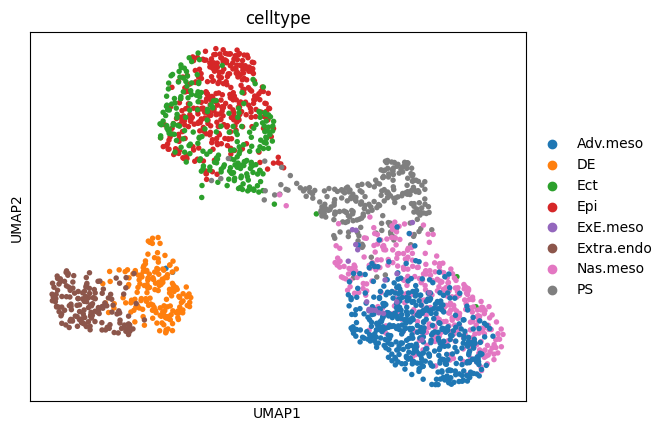

In [203]:
sc.pp.neighbors(Data_downsample, n_neighbors=10, n_pcs=40)
sc.tl.umap(Data_downsample)
sc.pl.umap(Data_downsample, color=["celltype"])

In [3]:
# Data_downsample.write(data_path + "downsample_1930_cells.h5ad")
Data_downsample = sc.read_h5ad(data_path + "downsample_1930_cells.h5ad")
Data_downsample.var_names_make_unique
Data_downsample

/home/zhiyuanlab/miniconda3/envs/test_wq/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1930 × 33538
    obs: 'cluster', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [214]:
ExpMat = Data_downsample.X.todense()
ExpMat = pd.DataFrame(ExpMat)
ExpMat.columns = Data_downsample.var.index
ExpMat.index = Data_downsample.obs.index
ExpMat

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
cellname,,,,,,,,,,,,,,,,,,,,,
TACATTCAGCGAAACC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CATGCAACAACCGTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TGGAGGAAGTGCAAAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CTCAAGATCTACGCGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTCCTAAAGCCTAGGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTGAGTTGTACGGGAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CTCATCGTCCGTGCGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TATTGGGGTGACAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [216]:
# ExpMat.to_csv(data_path + "ExpMat_lognorm_1930_cells_33538_genes.csv", index = True, sep = ",")
ExpMat = pd.read_csv(data_path + "ExpMat_lognorm_1930_cells_33538_genes.csv", index_col=0)

In [225]:
meta_info = Data_downsample.obs
meta_info

,cluster,celltype
cellname,,
TACATTCAGCGAAACC-1,1,Epi
CATGCAACAACCGTGC-1,1,Epi
TGGAGGAAGTGCAAAT-1,1,Epi
CTCAAGATCTACGCGG-1,1,Epi
TTCCTAAAGCCTAGGA-1,1,Epi
...,...,...
GTGAGTTGTACGGGAT-1,8,ExE.meso
CTCATCGTCCGTGCGA-1,8,ExE.meso
TATTGGGGTGACAGCA-1,8,ExE.meso


In [227]:
# meta_info.to_csv(data_path + "meta_info_1930_cells.csv", index = True, sep = ",")
meta_info = pd.read_csv(data_path + "meta_info_1930_cells.csv", index_col=0)

In [6]:
umap_embedding = Data_downsample.obsm["X_umap"]
umap_embedding = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])
umap_embedding.index = Data_downsample.obs.index
umap_embedding

,UMAP1,UMAP2
cellname,,
TACATTCAGCGAAACC-1,5.026833,10.258402
CATGCAACAACCGTGC-1,3.201978,9.906981
TGGAGGAAGTGCAAAT-1,2.445115,7.552279
CTCAAGATCTACGCGG-1,3.071553,13.109545
TTCCTAAAGCCTAGGA-1,3.334198,9.794472
...,...,...
GTGAGTTGTACGGGAT-1,8.605271,3.350821
CTCATCGTCCGTGCGA-1,9.504176,1.035150
TATTGGGGTGACAGCA-1,8.930046,4.147309


In [8]:
# umap_embedding.to_csv(data_path + "embedding_umap_1930_cells.csv", index = True, sep = ",")
umap_embedding = pd.read_csv(data_path + "embedding_umap_1930_cells.csv", index_col=0)